In [37]:
import tensorflow as tf
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import segmentation_models as sm

In [38]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128

#Capture training image info as a list
train_images = []
train_masks = []

dataset_dr = "LabeledTomatoLeaves"

for directory_path in glob.glob(dataset_dr + "/images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  
        # img = cv2.imread(img_path,0)
        img = cv2.resize(img, (SIZE_X, SIZE_Y))     
        train_images.append(img)
        mask_path = img_path.replace('/images', '/labels').replace('.jpg', '.png')
        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        train_masks.append(mask)
    for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
        img = cv2.resize(img, (SIZE_X, SIZE_Y))
        train_images.append(img)
        mask_path = img_path.replace('/images', '/labels').replace('.JPG', '.png')
        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X)) 
        train_masks.append(mask)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
        img = cv2.resize(img, (SIZE_X, SIZE_Y))   
        train_images.append(img)
        mask_path = img_path.replace('/images', '/labels').replace('.jpeg', '.png')
        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        train_masks.append(mask)
#Convert list to array for machine learning processing        
train_images = np.array(train_images, dtype=object)
print(train_images.shape)

#Capture mask/label info as a list
# train_masks = [] 
# for directory_path in glob.glob(dataset_dr + "/labels"):
#     for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
#         mask = cv2.imread(mask_path)       
#         # img = cv2.resize(img, (SIZE_X, SIZE_Y))
#         mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
#         #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
#         train_masks.append(mask)
#         #train_labels.append(label)
# #Convert list to array for machine learning processing          
train_masks = np.array(train_masks, dtype=object)
print(train_masks.shape)

#Use customary x_train and y_train variables
X = train_images
Y = train_masks


from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

x_train = np.asarray(x_train).astype('float32')
x_val = np.asarray(x_val).astype('float32')
y_train = np.asarray(y_train).astype('float32')
y_val = np.asarray(y_val).astype('float32')

x_train = tf.convert_to_tensor(x_train)
x_val = tf.convert_to_tensor(x_val)
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)

print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

# plt.imshow(tf.keras.utils.array_to_img(y_train[0]))

(66, 128, 128, 3)
(66, 128, 128, 3)
(52, 128, 128, 3) (14, 128, 128, 3)
(52, 128, 128, 3) (14, 128, 128, 3)


In [39]:
BACKBONE = 'inceptionv3'
preprocess_input = sm.get_preprocessing(BACKBONE)

x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True, classes=3, activation='softmax')
model.compile('Adam', loss=sm.losses.CategoricalFocalLoss() , metrics=[sm.metrics.iou_score])

2023-03-10 15:59:58.459974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step


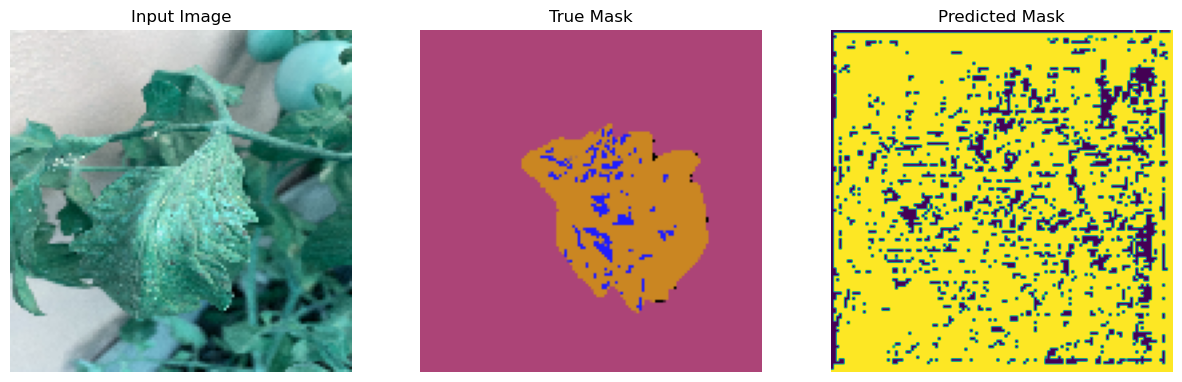

In [40]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

sample_image = x_train[1]
sample_mask = y_train[1]
show_predictions()
# print(sample_image.shape)
# model.predict(sample_image[tf.newaxis, ...])

1/1 [==============================] - 0s 431ms/step


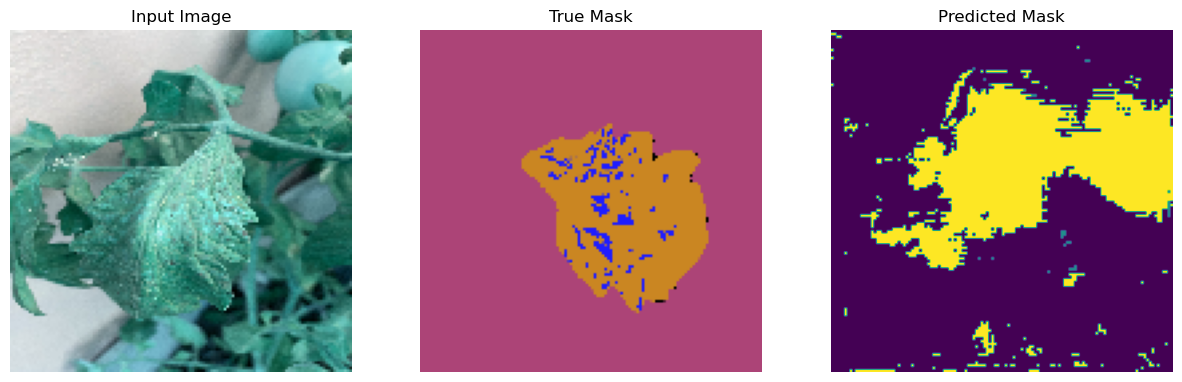


Sample Prediction after epoch 14

13/13 [==============================] - 3s 225ms/step - loss: 11.5898 - iou_score: 0.5525 - val_loss: 12.2893 - val_iou_score: 0.5343
Epoch 15/50
 8/13 [=================>............] - ETA: 0s - loss: 11.5369 - iou_score: 0.5556

KeyboardInterrupt: 

In [41]:
EPOCHS=50

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=4,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[DisplayCallback()]
)

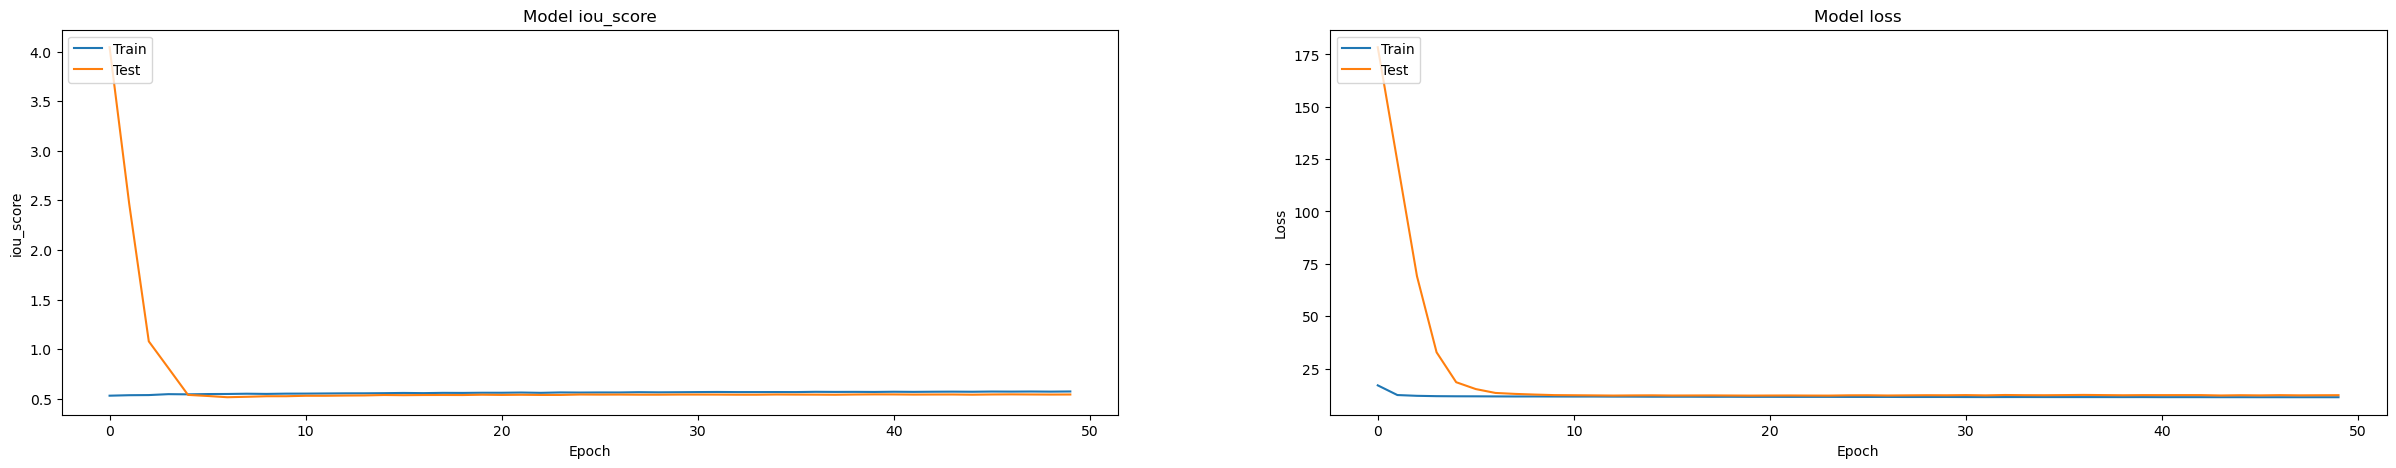

In [42]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()